Housekeeping

In [1]:
import os
import zipfile

In [2]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
#extract to folder
zip_path = os.path.join(os.getcwd(), "faces.zip")

# Specify the directory to extract the contents
extract_path = os.path.join(os.getcwd(), "faces")

# Create the extraction directory
os.makedirs(extract_path, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Create custom dataset

In [4]:
#create dictionary of labels to assign to the images
classes = sorted(os.listdir(os.path.join(extract_path, "train")))
labels = {label:i for (i, label) in enumerate(classes)}
labels, classes

({'angry': 0,
  'disgust': 1,
  'fear': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprise': 6},
 ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

In [5]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

In [6]:
class CustomImageDataset(Dataset):
  def __init__(self, root_dir, split):
    self.root_dir = os.path.join(root_dir, split)
    self.split = split
    self.images = self.combine_img_label()

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img, label = self.images[idx]
    return img, label

  #combine image paths with their corresponding labels and append to list
  def combine_img_label(self):
    images = []
    #iterate through each class, extracting images from corresponding class folder
    for cls in classes:
      class_path = os.path.join(self.root_dir, cls)
      label = labels[cls] #get the label number for that class
      #iterate through each image in the class folder
      for filename in os.listdir(class_path):
        img_path = os.path.join(class_path, filename)
        pil_image = Image.open(img_path)
        image = transforms.ToTensor()(pil_image) #transform to tensor
        images.append((image, label)) #append (image tensor, label)
    return images

In [7]:
directory = extract_path #./faces
train_dataset = CustomImageDataset(directory, "train")
test_dataset = CustomImageDataset(directory, "test")

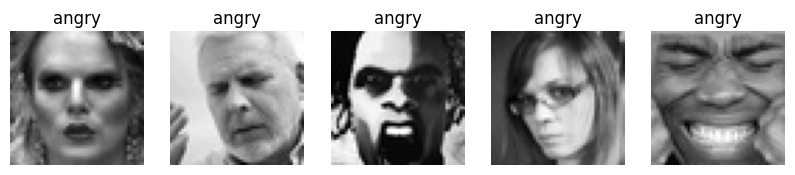

In [8]:
#visualize some pictures
import matplotlib.pyplot as plt

plt.figure(figsize= (10, 10))
for i in range(5):
  img, label = train_dataset[i]
  plt.subplot(1, 5, i+1)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(classes[label])
  plt.axis("off")

Turn train/test datasets into dataloaders

In [9]:
from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=True)

In [10]:
#sanity check
print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {batch_size}")

image_batch, label_batch = next(iter(train_dataloader))
print(f"Image batch shape: {image_batch.shape}")
print(f"Label batch shape: {label_batch.shape}")

Length of train dataloader: 449 batches of 64
Length of test dataloader: 113 batches of 64
Image batch shape: torch.Size([64, 1, 48, 48])
Label batch shape: torch.Size([64])


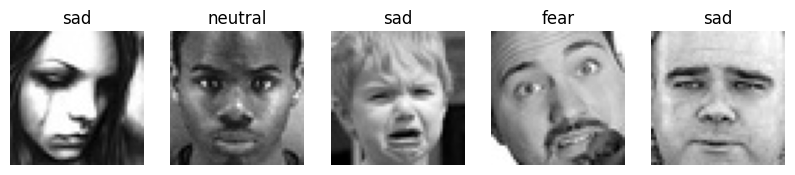

In [11]:
#visualize some images from batch
random_idx = torch.randint(0, len(image_batch), size=[5]).tolist() #get random indices

plt.figure(figsize= (10, 10))
for i, batch_idx in enumerate(random_idx):
  img, label = image_batch[batch_idx], label_batch[batch_idx]
  plt.subplot(1, 5, i+1)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(classes[label])
  plt.axis("off")

Create model

In [12]:
from torch import nn
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3), #32, 46, 46
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3), #64, 44, 44
            nn.ReLU(),
            nn.MaxPool2d(2), #64, 22, 22
            nn.Dropout(0.3))
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3), #128, 20, 20
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3), #128, 18, 18
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), #128, 9, 9
            nn.Dropout(0.3))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*9*9, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, len(classes)))
    def forward(self, x: torch.Tensor):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.classifier(x)
      return x

In [13]:
torch.manual_seed(42)
model = CNN().to(device)
model

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.3, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10368, out_features=1024, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=1024, out_features=7, bias=True)
  )
)

Create training/testing loop

In [14]:
from tqdm.auto import tqdm

In [15]:
def train_model(model, criterion, optimizer, epochs=100):
  #for graphing
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  #training loop
  for epoch in tqdm(range(epochs)):
    train_loss = 0
    train_total = 0
    train_correct = 0
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        #calculate accuracy
        train_total += y.shape[0]
        _, predicted = torch.max(y_pred.data, 1)
        train_correct += (predicted == y).sum().item()
        #calculate loss
        loss = criterion(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    train_accuracy = (train_correct/train_total)*100
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)

    #testing loop
    test_loss_total = 0
    #calculate accuracy
    test_total = 0
    test_correct = 0
    model.eval()
    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(test_dataloader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_test_pred = model(X_test)

            #calculate accuracy
            test_total += y_test.shape[0]
            _, predicted = torch.max(y_test_pred.data, 1)
            test_correct += (predicted == y_test).sum().item()

            #calculate loss
            test_loss = criterion(y_test_pred, y_test)
            test_loss_total += test_loss

        test_loss_total /= len(test_dataloader)
        test_accuracy = (test_correct / test_total) * 100
        test_losses.append(test_loss_total)
        test_acc.append(test_accuracy)


    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.4f}  | Train accuracy: {train_accuracy:.2f}% | Test Accuracy: {test_accuracy:.2f}%")
  return train_losses, test_losses, train_acc, test_acc

Train model

In [16]:
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses, train_acc, test_acc = train_model(model, loss_fn, optimizer, epochs=epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Loss: 1.674 | Test loss: 1.5047  | Train accuracy: 32.77% | Test Accuracy: 41.86%
Epoch: 10 | Loss: 0.791 | Test loss: 1.1194  | Train accuracy: 70.99% | Test Accuracy: 59.79%
Epoch: 20 | Loss: 0.468 | Test loss: 1.2617  | Train accuracy: 82.74% | Test Accuracy: 60.95%
Epoch: 30 | Loss: 0.358 | Test loss: 1.4014  | Train accuracy: 87.09% | Test Accuracy: 61.20%
Epoch: 40 | Loss: 0.292 | Test loss: 1.4039  | Train accuracy: 89.63% | Test Accuracy: 60.74%
Epoch: 50 | Loss: 0.265 | Test loss: 1.4762  | Train accuracy: 90.69% | Test Accuracy: 60.27%
Epoch: 60 | Loss: 0.232 | Test loss: 1.5458  | Train accuracy: 91.71% | Test Accuracy: 61.27%
Epoch: 70 | Loss: 0.215 | Test loss: 1.4708  | Train accuracy: 92.39% | Test Accuracy: 60.55%
Epoch: 80 | Loss: 0.199 | Test loss: 1.6055  | Train accuracy: 93.25% | Test Accuracy: 60.70%
Epoch: 90 | Loss: 0.191 | Test loss: 1.6573  | Train accuracy: 93.20% | Test Accuracy: 60.87%


Plot loss/accuracy curves

In [17]:
#convert tensors to np arrays
train_losses = [tensor.item() for tensor in train_losses]
test_losses = [tensor.item() for tensor in test_losses]

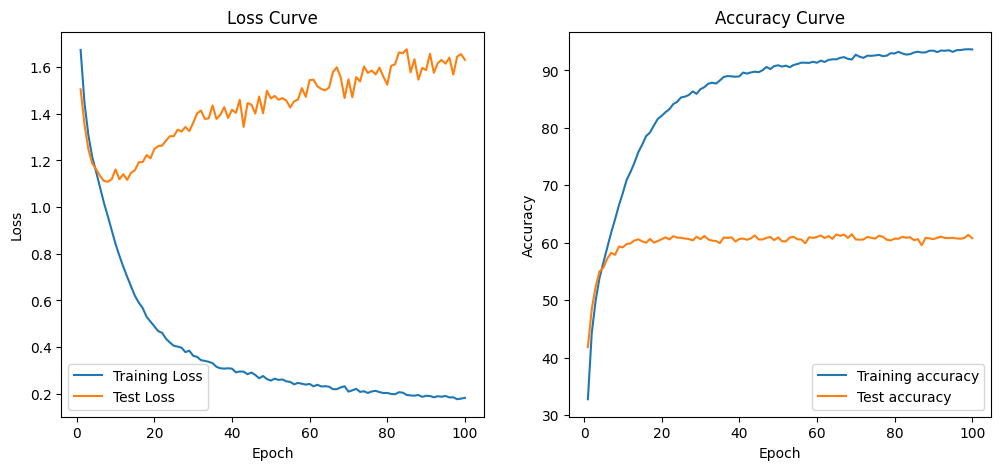

In [18]:
plt.figure(figsize=(12,5))
#plot train/test losses
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

#plot train/test accuracies
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_acc, label='Training accuracy')
plt.plot(range(1, epochs+1), test_acc, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()


Results/evaluation

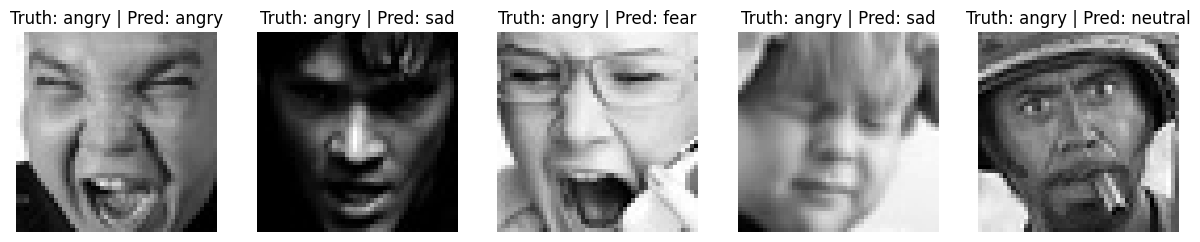

In [19]:
#make some predictions
plt.figure(figsize=(15,7))
for i in range(5):
    img = test_dataset[i][0]
    label = test_dataset[i][1]
    #make prediction
    model_pred = model(img.unsqueeze(dim=0).to(device))
    model_probs = torch.softmax(model_pred, dim=1)
    pred_label = torch.argmax(model_probs, dim=1)

    plt.subplot(1, 5, i+1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Truth: {classes[label]} | Pred: {classes[pred_label.cpu().item()]}")
    plt.axis("off")

In [20]:
#make predictions across test set
model.eval()
y_preds = []
y_actual = []
with torch.inference_mode():
    for batch, (X,y) in tqdm(enumerate(test_dataloader)):
        X, y = X.to(device), y.to(device)
        y_pred_logits = model(X)
        y_pred_probs = torch.softmax(y_pred_logits, dim=1)
        y_pred_label = torch.argmax(y_pred_probs, dim=1)
        y_preds.append(y_pred_label)
        y_actual.append(y)
    y_preds = torch.cat(y_preds).cpu()
    y_actual = torch.cat(y_actual).cpu()
len(y_preds), len(y_actual)

0it [00:00, ?it/s]

(7178, 7178)

In [ ]:
!pip install torchmetrics mlxtend

In [23]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [24]:
#create confusion matrix
cm = ConfusionMatrix(task="multiclass", num_classes=len(classes))
y_preds = torch.tensor(y_preds)
cm_tensor = cm(y_preds, y_actual)

<ipython-input-24-3542e5a2e6bd>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_preds = torch.tensor(y_preds)


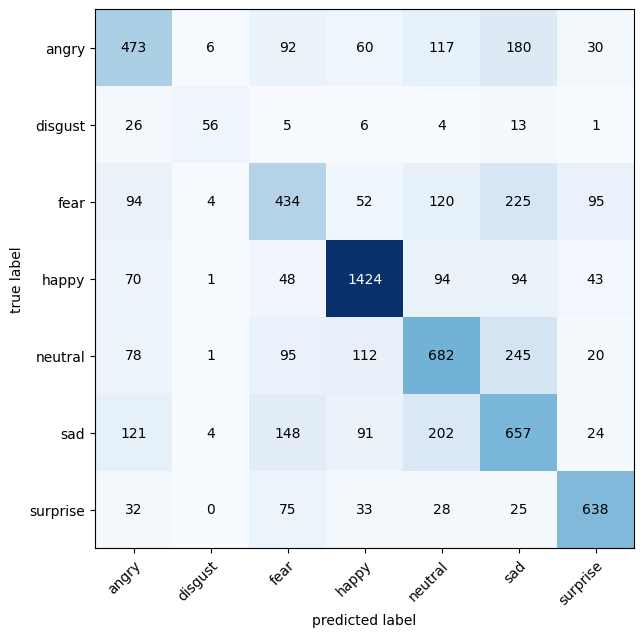

In [25]:
fix, ax = plot_confusion_matrix(cm_tensor.numpy(), class_names=classes, figsize=(10,7))

Save model

In [26]:
from pathlib import Path
path = Path("models")
path.mkdir(parents=True, exist_ok=True)

name = "model.pth"
model_save_path = path / name
torch.save(model.state_dict(), model_save_path)